# NYC Property sale data analysis

In [97]:
import numpy as np
import pandas as pd
import datetime
from scipy.spatial import distance

import ipywidgets as widgets
from ipywidgets import IntSlider

from datascience import *
from datetime import timedelta
from datetime import date
from datetime import datetime
import time

from IPython.display import display
from IPython.display import HTML

# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from constants import *
from functions import *

import locale
%load_ext line_profiler



The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Import Data

In [2]:

# All Condos
df = pd.read_csv(csv_directory+'condos.csv')

#SALE DATE is object but should be datetime
df[COL_SALE_DATE] = pd.to_datetime(df[COL_SALE_DATE], errors='coerce')

# remove additional whitespace in strings
df = df.applymap(lambda x: x.strip() if type(x) is str else x)

# 
condos = Table.from_df(df)


df = pd.read_csv(csv_directory+'condo_sales.csv')

# DATE is  but should be datetime
df[ COL_PURCHASE_DATE] = pd.to_datetime(df[COL_PURCHASE_DATE], errors='coerce')
df[ COL_SOLD_DATE] = pd.to_datetime(df[COL_SOLD_DATE], errors='coerce')

condo_sales = Table.from_df(df)


# Understanding the data

Let's try to get an overview of the data by looking at the movement of the average sale price per year.

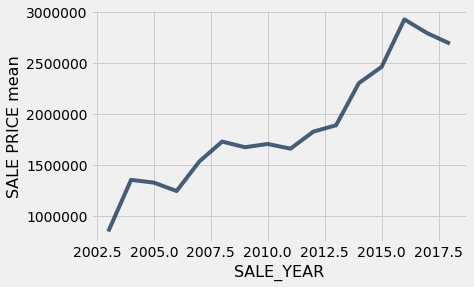

In [3]:
years = [ d.year for d in condos.column(COL_SALE_DATE) ]

months = [ d.month for d in condos.column(COL_SALE_DATE) ]

condos = condos.with_column('SALE_YEAR', years, 'SALE_MONTH', months)

condo_mean = condos.select(COL_SALE_YEAR, COL_SALE_PRICE).group(COL_SALE_YEAR, np.mean).sort(0)
condo_mean.plot(COL_SALE_YEAR)



## Sales by neighbourhood 

Also helpful to usederstand how prices have changed in different neighborhoods. 

In [4]:
neighborhoods = condos.group('NEIGHBORHOOD').sort(0).column(0)


def plot_neighborhood(neighborhood:str):
    '''Plot the average sale for a specified neign'''
    condos.where('NEIGHBORHOOD', are.equal_to(neighborhood)).select(COL_SALE_YEAR, COL_SALE_PRICE).group(0, np.mean).plot(0, label=neighborhood)
    plots.title = neighborhood
    plots.plot(condo_mean.column(0), condo_mean.column(1), color='gold', label='' )
    return

interact(plot_neighborhood, neighborhood=neighborhoods)


interactive(children=(Dropdown(description='neighborhood', options=('ALPHABET CITY', 'CHELSEA', 'CHINATOWN', '…

<function __main__.plot_neighborhood(neighborhood: str)>

## Sampling

Let's take a deeper dive at apartment sales in 2010 as a sample. Note: we could have selected any range. This is just a random selection to reduce the noise in the data



Correlation betweeen Price Change and Time:  0.12950919409279943


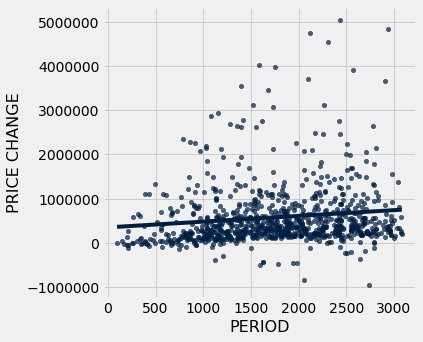

In [5]:
sales_2010 = condo_sales.where(COL_PURCHASE_DATE, are.between( datetime.datetime(2010, 1, 1), datetime.datetime(2010, 12, 31)))

Table().with_columns(
    'PERIOD',  sales_2010.column(COL_PERIOD), 
    'PRICE CHANGE', sales_2010.column(COL_PRICE_CHANGE)
).scatter(0, 1, fit_line=True)

print('Correlation betweeen Price Change and Time: ', correlation(sales_2010, COL_PERIOD, COL_PRICE_CHANGE))

That's a low correlation, I was expectating a closer relationship that is roghly keeping tracking with avg overall sale price we plotted earlier.


Ok, let's look at the correlation between the first and last sale price. 

0.9481282677701287

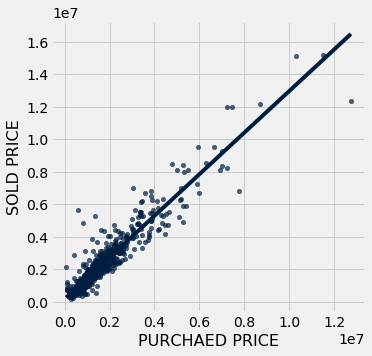

In [6]:
Table().with_columns(
    'PURCHASED PRICE',  sales_2010.column(COL_PURCHASE_PRICE), 
    'SOLD PRICE', sales_2010.column(COL_SOLD_PRICE)
).scatter(0, fit_line=True)

correlation(sales_2010, COL_PURCHASE_PRICE, COL_SOLD_PRICE)



Wow that's a really high correlation. According to this we could predict the last sale price of a property, just based on it's first sale price. i.e. independent of the time between sales! 

Somehting doesn't seem right, we know that the market moves over time. Let's dig in a little deeper and plot the residuals

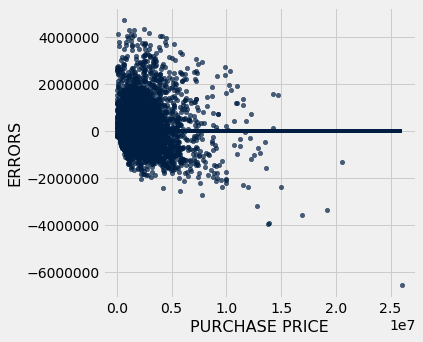

In [7]:
a = slope(condo_sales, COL_PURCHASE_PRICE, COL_SOLD_PRICE)
b = intercept(condo_sales, COL_PURCHASE_PRICE, COL_SOLD_PRICE)

first_prices = condo_sales.column(COL_PURCHASE_PRICE)

predicted = first_prices * a + b

errors = condo_sales.column(COL_SOLD_PRICE) - predicted


Table().with_columns(
    'PURCHASE PRICE',  condo_sales.column(COL_PURCHASE_PRICE), 
    'ERRORS', errors
).scatter(0, fit_line=True)



The residuals are not evenly spread put, also some large outliers are skewing the results so a liner regression model isn't the right approach here.

Let's take a deeper look into a particular bands to see what could be going on. 

0.2724300121488233

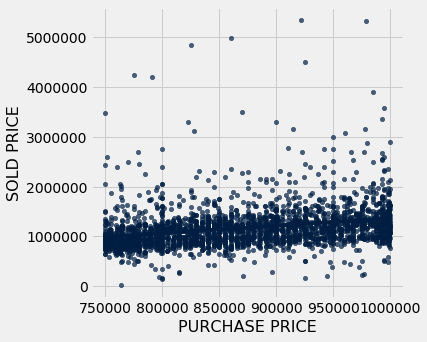

In [8]:
price_band = condo_sales.where(COL_PURCHASE_PRICE, are.between(750000, 1000000))

price_band.scatter(COL_PURCHASE_PRICE, COL_SOLD_PRICE, fit_line=True)
correlation(price_band, COL_PURCHASE_PRICE, COL_SOLD_PRICE)

Now the correlation is much lower, The data is more spread out. Also a average seems to skew a little higher do the outliers a visible in the chart.

## Removing Outliers

Let's look at the purchase price outliers

PURCHASE PRICE Stats
Avg: 1333816.016063412 	Std: 1321190.8990423337 	Min: 11753 	Max: 26022485
 5%: 278000 	95%: 3600000
 1%: 142671 	99%: 6669538
25%: 580000 	50%: 932500 	75% 1629200


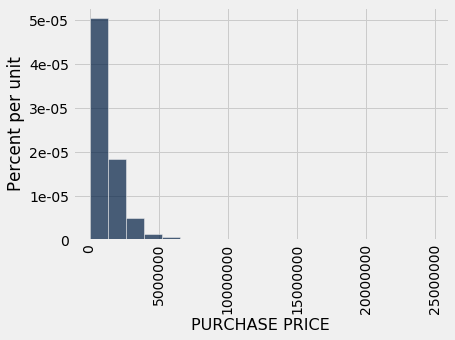

In [9]:
col_stats(condo_sales, COL_PURCHASE_PRICE)

Let's remove the ouliers so we can get a better picture of the data. 

PURCHASE PRICE Stats
Avg: 1265149.4731228973 	Std: 1014645.4209814112 	Min: 142671 	Max: 6669537
 5%: 298866 	95%: 3350000
 1%: 200000 	99%: 5250000
25%: 585493 	50%: 932500 	75% 1610000


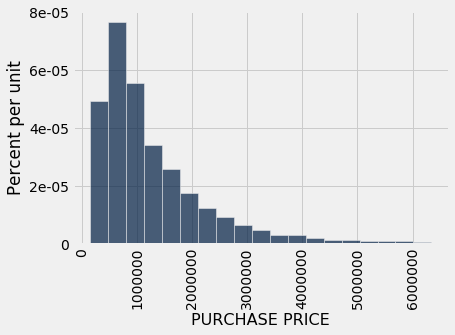

In [10]:
purchase_prices = condo_sales.column(COL_PURCHASE_PRICE)

percent_1 = percentile(1, purchase_prices)
percent_99 = percentile(99, purchase_prices)

condo_sales = condo_sales.where(COL_PURCHASE_PRICE, are.between(percent_1, percent_99))
col_stats(condo_sales, COL_PURCHASE_PRICE)

much better!

# Price change % 

Now let's calculate the price change as a % of the purchase price.

In [11]:
percents = sales_2010.column(COL_PRICE_CHANGE) / sales_2010.column(COL_PURCHASE_PRICE) * 100

COL_PRICE_PERCENT = 'PRICE CHANGE %'

sales_2010 = sales_2010.with_column(COL_PRICE_PERCENT, percents)



## Sanitize price change % 

Looking into how  the price change % data is distributed. Again we need to clean out the outliers.

PRICE CHANGE % Stats
Avg: 53.35357017034671 	Std: 129.39169442541132 	Min: -60.02098971213591 	Max: 3054.111347465708
 5%: 0.0 	95%: 103.81328073635765
 1%: -29.6875 	99%: 487.8787878787879
25%: 23.544303797468356 	50%: 39.24050632911392 	75% 57.05128205128205


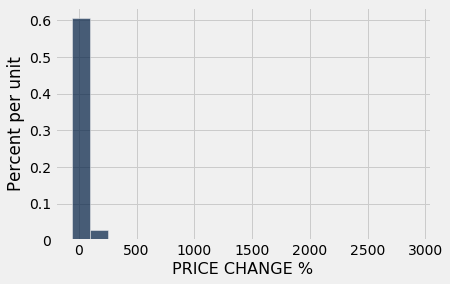

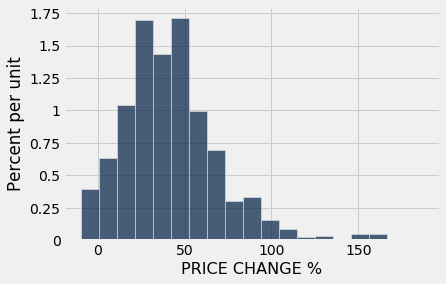

In [12]:

col_stats(sales_2010, COL_PRICE_PERCENT)
draw_hist(sales_2010, COL_PRICE_PERCENT, 2)

In [13]:
# strip out the Price Percent change outliers. 

price_changes = sales_2010.column(COL_PRICE_PERCENT)

percent_2 = percentile(2, price_changes)
percent_98 = percentile(98, price_changes)

sales_2010 = sales_2010.where(COL_PRICE_PERCENT, are.between(percent_2, percent_98))



0.33006786771399327

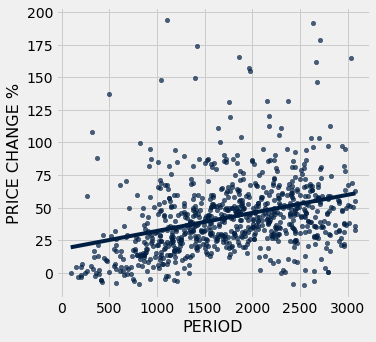

In [14]:
sales_2010.scatter(COL_PERIOD, COL_PRICE_PERCENT, fit_line=True)
correlation(sales_2010, COL_PERIOD, COL_PRICE_PERCENT)

Ok there there looks to be an upward trend here and prices changes increase over time. That said the correlation isn't linear. Smoothing the data into monthly (30) intervals look like the following

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


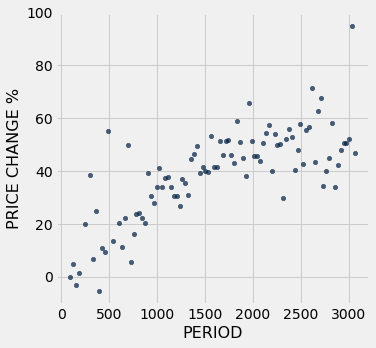

In [15]:

periods = sales_2010.column(COL_PERIOD)

min_period = min(periods)
max_period = max(periods)


period_groups = []
period_sales = []

for i in np.arange(min_period, max_period, 30 ):
    period_groups.append(i)
    period_sales.append(np.mean(sales_2010.where(COL_PERIOD, are.between(i, i+30)).column(COL_PRICE_PERCENT)))
    

Table().with_columns(
    COL_PERIOD,  period_groups, 
    COL_PRICE_PERCENT, period_sales
).scatter(0)

Defintitely shows a trend! 

Let's take a look at other years

In [16]:
# Trim the outliers. 
percents = condo_sales.column(COL_PRICE_CHANGE) / condo_sales.column(COL_PURCHASE_PRICE) * 100

condo_sales = condo_sales.with_column(COL_PRICE_PERCENT, percents)

percent_1 = percentile(1, percents)
percent_99 = percentile(99, percents)

condo_sales = condo_sales.where(COL_PRICE_PERCENT, are.between(percent_1, percent_99))

def plot_price_change_year(year):
    ''' Plot the price change % for a given year'''
    valid_sales = condo_sales.where(COL_PURCHASE_DATE, are.between_or_equal_to( datetime.datetime(year, 1, 1), datetime.datetime(year+1, 1, 1)))

    min_period = min(periods)
    max_period = max(periods)


    period_groups = []
    period_sales = []

    for i in np.arange(min_period, max_period, 30 ):
        period_groups.append(i)
        period_sales.append(np.mean(valid_sales.where(COL_PERIOD, are.between(i, i+30)).column(COL_PRICE_PERCENT)))

    Table().with_columns(
        COL_PERIOD,  period_groups, 
        COL_PRICE_PERCENT, period_sales
    ).scatter(0)

interact(plot_price_change_year, year=np.arange(2003,2019) )



interactive(children=(Dropdown(description='year', options=(2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 20…

<function __main__.plot_price_change_year(year)>

We can now say there is a a correlation between the price change and time reflective of the overall movement in the market over time. 

Let's create some prediction models. 

# Predicting NYC property prices

## Prediction model: nearest neighbor

Our prediction model should use both the purchase price and date for prediction. Let's create it now.

We will first convert purchase date, price and sold dates into standard units so they can be used to compute distance. 

There we will create the training and testing set.

In [25]:
# Convert to standard units
purchase_dates_timestamps = [ date.timestamp() for date in condo_sales.column(COL_PURCHASE_DATE)]
purchase_dates_su = standard_units(purchase_dates_timestamps)

sold_dates_timestamps = [ date.timestamp() for date in condo_sales.column(COL_SOLD_DATE)]
sold_dates_su = standard_units(sold_dates_timestamps)

purchase_price_su = standard_units(condo_sales.column(COL_PURCHASE_PRICE))

condo_sales_su = condo_sales.with_column(
    COL_PURCHASE_DATE_SU, purchase_dates_su, 
    COL_PURCHASE_PRICE_SU, purchase_price_su, 
    COL_SOLD_DATE_SU, sold_dates_su,
)

# Create the training and testing sets.
training_sales, test_sales = condo_sales_su.split(int(condo_sales.num_rows * 0.6))
training_sales


FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE,PRICE CHANGE,PERIOD,DAILY PRICE CHANGE,PRICE CHANGE %,PURCHASE DATE SU,PURCHASE PRICE SU,SOLD DATE SU
"165 WEST 91ST STREET, 9E",2014-03-27 00:00:00,2540533,2016-03-18 00:00:00,2525000,-15533,722,-21.5139,-0.611407,2.13163,1.24045,0.743138
"225 EAST 34TH STREET, 6C",2007-09-25 00:00:00,1288086,2013-06-14 00:00:00,1350000,61914,2089,29.6381,4.80667,-0.0191157,0.0112121,-0.000968308
"505 WEST 47TH STREET, 3F-N",2011-08-26 00:00:00,659000,2017-04-25 00:00:00,870000,211000,2069,101.982,32.0182,1.27677,-0.606214,1.04063
"100 RIVERSIDE BOULEVARD, 8D",2008-04-04 00:00:00,797671,2013-01-23 00:00:00,816000,18329,1755,10.4439,2.29781,0.154755,-0.470113,-0.105793
"308 EAST 72ND STREET, 4A",2009-05-08 00:00:00,1995000,2011-07-26 00:00:00,1700000,-295000,809,-364.648,-14.787,0.516081,0.705024,-0.509588
"160 WADSWORTH AVENUE, 504",2014-08-06 00:00:00,382500,2016-11-02 00:00:00,545000,162500,819,198.413,42.4837,2.25117,-0.877589,0.912185
"447 WEST 18TH STREET, 2B",2009-07-30 00:00:00,878240,2018-02-15 00:00:00,1340000,461760,3122,147.905,52.5779,0.591244,-0.391038,1.25914
"225 EAST 46 STREET, 8B",2003-01-08 00:00:00,245000,2004-01-20 00:00:00,285000,40000,377,106.101,16.3265,-1.57762,-1.01254,-2.53521
"90 WILLIAM STREET, 15B",2009-10-22 00:00:00,950000,2014-09-08 00:00:00,1500000,550000,1782,308.642,57.8947,0.667313,-0.320608,0.33196
"212 EAST 70TH STREET, 3C",2007-11-02 00:00:00,687318,2017-05-26 00:00:00,675000,-12318,3493,-3.52648,-1.79218,0.0152963,-0.578421,1.06352


In [29]:
distance_columns = [COL_PURCHASE_DATE_SU, COL_PURCHASE_PRICE_SU, COL_SOLD_DATE_SU]



def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.select(distance_columns)
    return distance.cdist( attributes.to_array().tolist(), [new_point]).flatten()

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def estimate(training, purchase_point, k):
    """Estimate a price based on nearest neighbours"""
    close_points = closest(training_sales, purchase_point, k)
    avg_price_change = np.mean(close_points.column(COL_PRICE_PERCENT))
    return avg_price_change

def evaluate_accuracy(training, test, k):
    """Evalute the accuracy of the model generating using training data on test data"""
    # select the columns to compare
    test_attributes = test.select(distance_columns)

    # compute the predicted change for each test row
    def price_testrow(row):
        return estimate(training, row, k)

    # Calculate the predicted price and error
    c = test_attributes.apply(price_testrow)
    
    estimated = test[COL_PURCHASE_PRICE] * (100 + c )/100
    error = (estimated - test[COL_SOLD_PRICE] ) / test[COL_SOLD_PRICE] * 100
    
    return test.with_column("Estimated", estimated, 'Error %', error)

In [30]:

sample_sales =  test_sales
estimates = evaluate_accuracy(training_sales, sample_sales, 10)


Error % Stats
Avg: 3.6444704815766644 	Std: 20.770743285175655 	Min: -64.33063856572858 	Max: 195.85331277048087
 5%: -28.132820323664475 	95%: 37.11469047288437
 1%: -44.55585358600915 	99%: 63.735406092284485
25%: -8.400238150878502 	50%: 2.9135499472309436 	75% 14.336491339502885


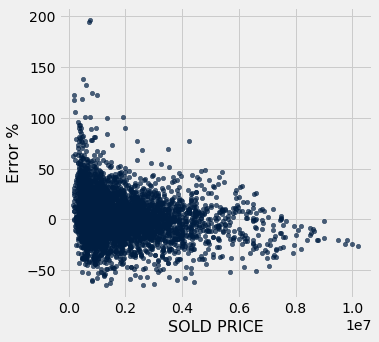

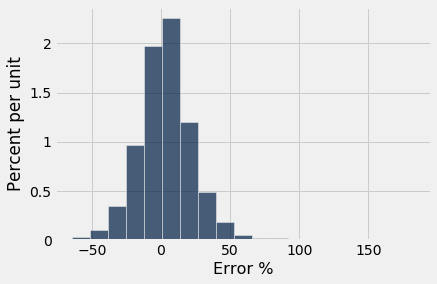

In [32]:
estimates.scatter(COL_SOLD_PRICE, 'Error %')

col_stats(estimates, "Error %")

In [99]:
def predict_sale_price(purchase_price, purchase_date: datetime.date):
    """Predict the current value based on the purchase price and purchase date."""
    
    purchase_date_timestamp = time.mktime(purchase_date.timetuple())

    # Set sold date to now
    sold_date = datetime.datetime.now().timestamp()

    # calcuate all values in standard units.
    purchase_date_su = (purchase_date_timestamp - np.mean(purchase_dates_timestamps)) / np.std(purchase_dates_timestamps)
    purchase_price_su = (purchase_price - np.mean(condo_sales.column(COL_PURCHASE_PRICE))) / np.std(condo_sales.column(COL_PURCHASE_PRICE))
    sold_date_su = (sold_date - np.mean(sold_dates_timestamps)) / np.std(sold_dates_timestamps)

    # debugging
    # print(purchase_date_su, purchase_price_su, sold_date_su)

    # create a target row to get estimates
    target_row = Table(distance_columns)
    target_row = target_row.with_row([purchase_date_su,purchase_price_su,sold_date_su ])
    
    price_change_percent = estimate(training_sales, target_row.row(0), 10)
    
    price = purchase_price * (1 + price_change_percent / 100)
    
    display(HTML("<H1>Estimated Price: ${:,.0f} </H1>".format(price)))
    display(HTML("<H2>Estimated Price Change: {:.2f}% </H2>".format(price_change_percent)))
    
    display(HTML("<H1>Compareable sales</H1>"))
    closest(training_sales, target_row.row(0), 10).show()
    
style = {'description_width': 'initial'}

purchase_price_slider = widgets.IntSlider(
    description="Purchase Price",
    value=750000,
    min=100000,
    max=10000000,
    step=10000,
    disabled=False,
    continuous_update=False,
    style=style
    
)

purchase_date_picker = widgets.DatePicker(
    description='Purchase Date',
    disabled=False,
    style=style,
    value=datetime.date(2010, 1, 1)
)

In [100]:
style = {'description_width': 'initial'}
IntSlider(description='A too long description', style=style)

interact( predict_sale_price, purchase_price=purchase_price_slider, purchase_date=purchase_date_picker, )



interactive(children=(IntSlider(value=750000, continuous_update=False, description='Purchase Price', max=10000…

<function __main__.predict_sale_price(purchase_price, purchase_date: datetime.date)>

In [66]:
965570.5724678704 * (1 - 0.27), 965570.5724678704 * (1 + 0.34)

(704866.5179015454, 1293864.5671069464)